# Solutions of the Binari Sudoku using Quantum Grover's algorithm on Quamtum IBM Plattform

The solution to the binary 2×2 grid Sudoku using Grover's algorithm was obtained by following the [Qiskit textbook](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/grover.ipynb). 
Since the notebook has not been updated in over a year, some lines of code no longer work as-is. I have made modifications and added code to demonstrate how to run the circuit on a freely available IBM Quantum Processing Unit (QPU).
If you'd like to run the code yourself, you'll need to set up your IBM Quantum account first. You can follow the instructions in the official [IBM set up doc](https://quantum.cloud.ibm.com/docs/es/guides/cloud-setup). 

In [13]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import MCXGate
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.append(MCXGate(num_ctrl_qubits=4), clause_qubits[:] + [output_qubit[0]])

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

When I tried to implement it myself, I grouped some parts into functions to make it easier to visualize, just like in the textbook.
However, for some reason I wasn't able to resolve some errors that appeared in the final circuit drawing, therefore the entire circuit appears unpacked instead of showing the modular structure.

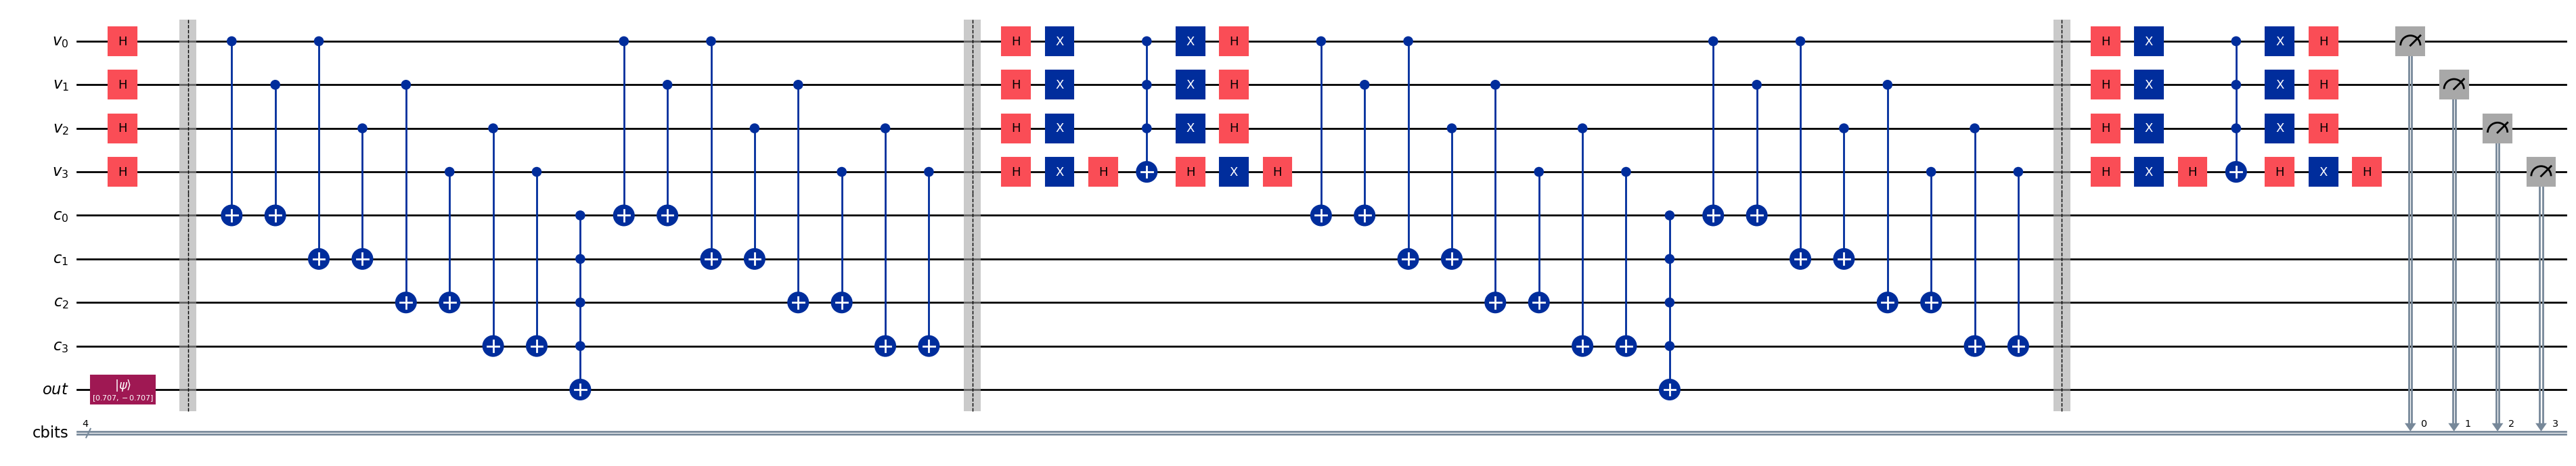

In [ ]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc0 = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

nqubits = 4  # number of variable qubits
# Initialize 'out0' in state |->
qc0.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in equally amplitude state |s>
qc0.h(var_qubits)
qc0.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc0, clause_list, clause_qubits)
qc0.barrier()  # for visual separation
# Apply our diffuser
for qubit in range(nqubits):
    qc0.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc0.x(qubit)
# Do multi-controlled-Z gate
qc0.h(nqubits-1)
controls = list(range(nqubits - 1))
target = nqubits - 1
qc0.append(MCXGate(len(controls)), qargs=controls + [target])
qc0.h(nqubits-1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc0.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc0.h(qubit)

## Second Iteration
sudoku_oracle(qc0, clause_list, clause_qubits)
qc0.barrier()  # for visual separation
# Apply our diffuser
for qubit in range(nqubits):
    qc0.h(qubit)
# Apply transformation |00..0> -> |11..1> (X-gates)
for qubit in range(nqubits):
    qc0.x(qubit)
# Do multi-controlled-Z gate
qc0.h(nqubits-1)
controls = list(range(nqubits - 1))
target = nqubits - 1
qc0.append(MCXGate(len(controls)), qargs=controls + [target])
qc0.h(nqubits-1)
# Apply transformation |11..1> -> |00..0>
for qubit in range(nqubits):
    qc0.x(qubit)
# Apply transformation |00..0> -> |s>
for qubit in range(nqubits):
    qc0.h(qubit)

# Measure the variable qubits
qc0.measure(var_qubits, cbits)

qc0.draw('mpl',fold=-1)

The ibm_brisbane QPU performed 4096 shots, so for the simulation I used 4200 shots.
It's quite clear from the simulation results that the correct solutions for the binary 2×2 grid Sudoku are obtained.

{'1111': 14, '0110': 1971, '1010': 18, '1001': 1998, '0101': 12, '1101': 22, '1000': 19, '0010': 20, '0100': 20, '1100': 12, '1011': 16, '0111': 16, '0001': 10, '1110': 16, '0000': 11, '0011': 25}


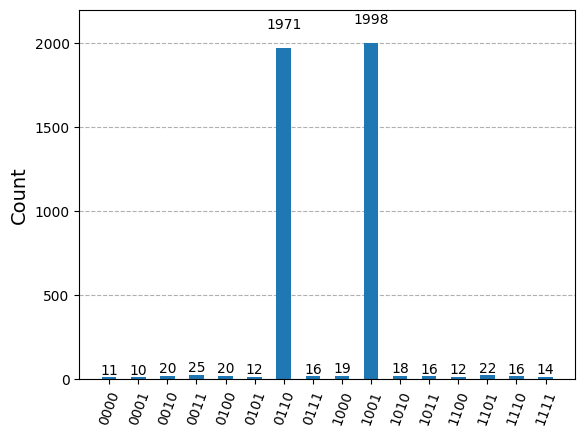

In [16]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

job = AerSimulator().run(qc0,shots=4200)
counts = job.result().get_counts(qc0)
print(counts)

plot_histogram(counts)

As mentioned at the beginning, you need to set up your IBM Quantum account to run the circuit on a real QPU.
These devices are obviously error propense, so we shouldn't expect results for circuits of this size.
In this case, the backend used is ibm_brisbane.

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = 'ibm_brisbane'
service = QiskitRuntimeService()  
backend = service.backend(backend_name)  

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)


from qiskit_ibm_runtime import SamplerV2 as Sampler
isa_circuit0 = pm.run(qc0)
print(f">>> Circuit ops (ISA): {isa_circuit0.count_ops()}")
sampler = Sampler(mode=backend)
job0 = sampler.run([(isa_circuit0)])
print(f">>> Job ID: {job0.job_id()}")

>>> Circuit ops (ISA): OrderedDict({'rz': 921, 'sx': 664, 'ecr': 346, 'x': 57, 'measure': 4, 'barrier': 3, 'reset': 1})
>>> Job ID: d201d29mr05s73a735n0


Counts for the 'meas' output register: {'1000': 260, '0010': 287, '1101': 235, '0000': 287, '0001': 275, '0101': 243, '0011': 292, '1011': 228, '1010': 250, '0111': 262, '1110': 241, '1111': 250, '0110': 290, '1001': 255, '0100': 237, '1100': 204}


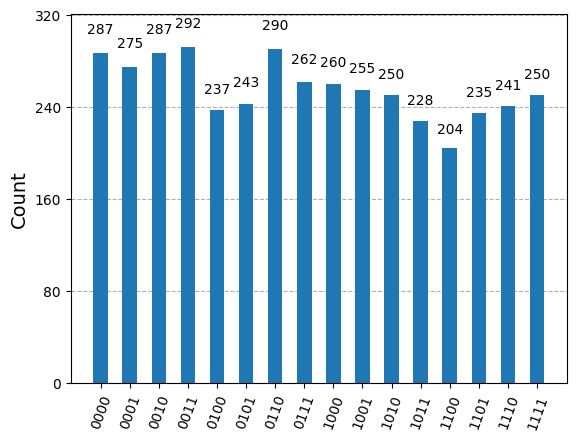

In [8]:
result0 = job0.result()
 
# Get results for the first (and only) PUB
pub_result0 = result0[0]
print(
    f"Counts for the 'meas' output register: {pub_result0.data.cbits.get_counts()}"
)

counts0 = pub_result0.data.cbits.get_counts()
plot_histogram(counts0)

The plot above shows that we are far from obtaining the simulation results, as we expected.
Below, we show the relative frequencies which makes it easier to see what we get.

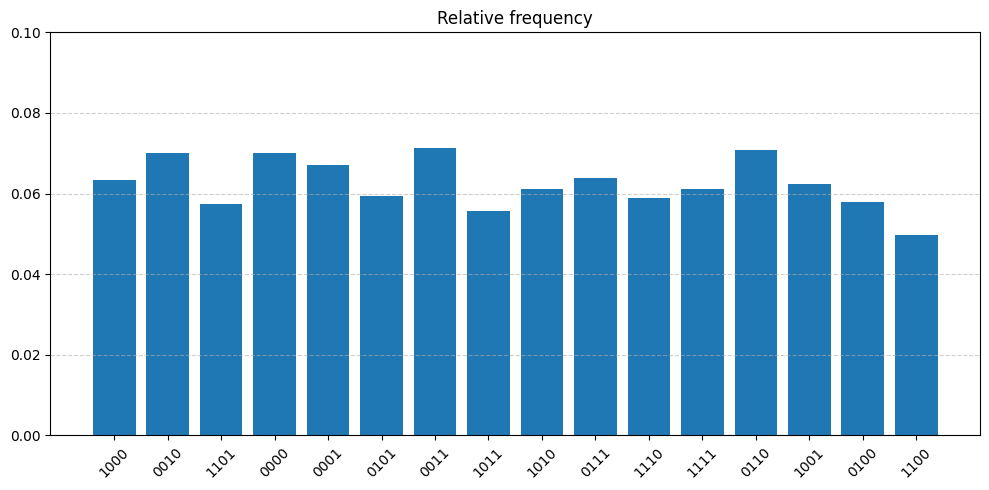

In [21]:
freq = {bitstring: count / 4096 for bitstring, count in counts0.items()}
plt.figure(figsize=(10, 5))
plt.bar(freq.keys(), freq.values())
plt.title("Relative frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.ylim(0, 0.1)
plt.tight_layout()
plt.show()

I’m just leaving these here to save the results.

In [20]:
import pandas as pd

df = pd.DataFrame(list(counts.items()), columns=['Bitstring', 'Frequency'])
df.to_csv('simulation.csv', index=False)

dfCounts0 = pd.DataFrame(list(counts0.items()), columns=['Bitstring', 'Frequency'])
dfCounts0.to_csv('ibmTest_Freq.csv', index=False)

df0 = pd.DataFrame(list(freq.items()), columns=['Bitstring', 'Relative Frequency'])
df0.to_csv('ibmTest_RFreq.csv', index=False)